# Определение стоимости автомобилей 

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


# Описание признаков

DateCrawled — дата скачивания анкеты

Price - цена, целевая переменная

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность

Model - модель

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты

LastSeen — дата последней активности пользователя

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


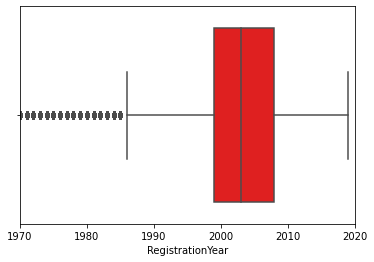

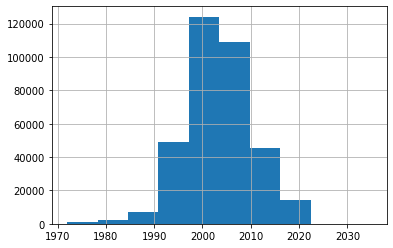

In [6]:
def boxplot_print(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    sns.boxplot(x=colum, color='red')   
    plt.show()
    colum.hist(bins=bins, range=((q1-3*iqr), (q3+3*iqr)))
    plt.show()
    
plt.xlim(1970, 2020)
boxplot_print(data['RegistrationYear'], 10)

In [7]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Repaired — была машина в ремонте или нет. Вероятней всего если пропущено значение, то машина не была в ремонте. По этой логике заменим пропуски на "no"

Из модельного ряда подобрать модель сложно, и чтобы дальнейшая обработка пропусков была точнее удалим пропущенные значения в столбце 'Model'.

In [8]:
data['Repaired'] = data['Repaired'].fillna('no')
data.dropna(subset=['Model'], inplace = True)
data['Repaired'].unique()

array(['no', 'yes'], dtype=object)

Остальные пропуски заменим наиболее частыми значения. Для этого сгруппируем даные по бренду и модели.

In [9]:
data.groupby(['Brand', 'Model'])['Gearbox'].value_counts()

Brand       Model     Gearbox
alfa_romeo  145       manual      40
            147       manual     520
                      auto        29
            156       manual     556
                      auto        45
                                ... 
volvo       v60       auto        14
            v70       manual     385
                      auto       225
            xc_reihe  auto       191
                      manual      68
Name: Gearbox, Length: 572, dtype: int64

In [10]:
data["VehicleType"] = (data.groupby(['Brand', 'Model'])['VehicleType']
                       .transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty"))))
data["Gearbox"] = (data.groupby(['Brand', 'Model'])['Gearbox']
                       .transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty"))))
data["FuelType"] = (data.groupby(['Brand', 'Model'])['FuelType']
                        .transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty"))))

data.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [11]:
data.duplicated().sum()

5

In [12]:
data = data.drop_duplicates().reset_index(drop=True)

In [13]:
data.duplicated().sum()

0

Определяем верхнюю границу года регистрации

In [14]:
date = pd.to_datetime(data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

count    322143.000000
mean       2002.656227
std           6.724669
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

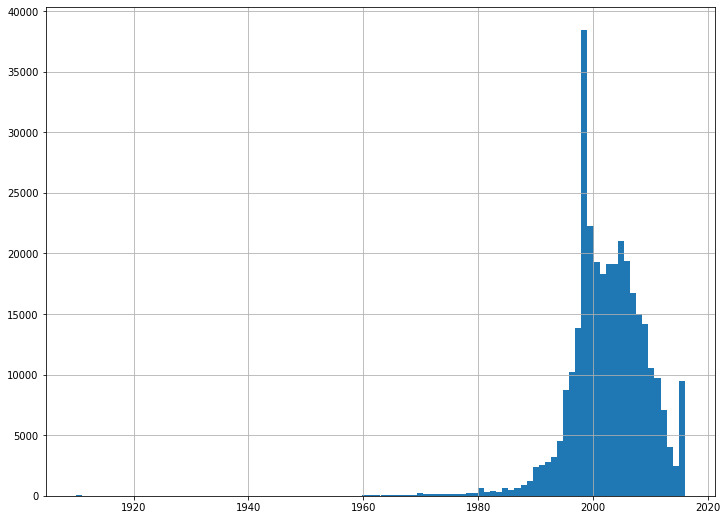

In [15]:
data = data.query('1899 < RegistrationYear < 2017')
data['RegistrationYear'].hist(bins=100, figsize=(12,9))
data['RegistrationYear'].describe()

Из гистограммы видно, что убираем данные до 1960 года: 

count    321949.000000
mean       2002.693299
std           6.540194
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

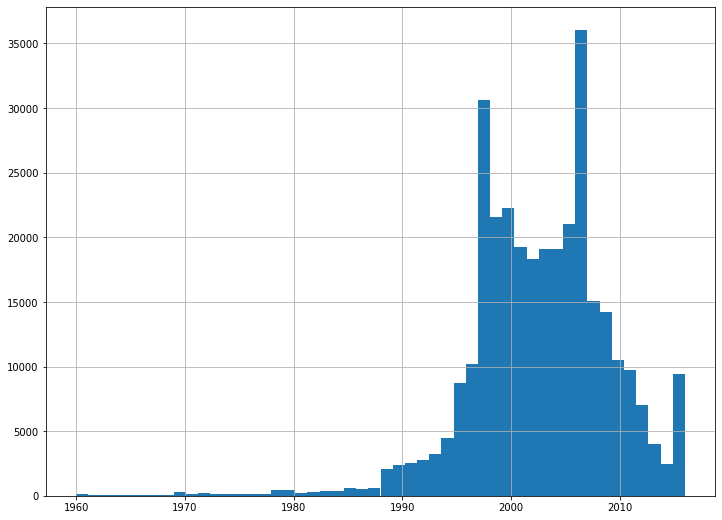

In [16]:
data = data.query('1959 < RegistrationYear < 2017')
data['RegistrationYear'].hist(bins=50, figsize=(12,9))
data['RegistrationYear'].describe()

Удаляем даты:

In [17]:
data = data.drop(['DateCrawled', 'DateCreated' , 'LastSeen'], axis=1)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


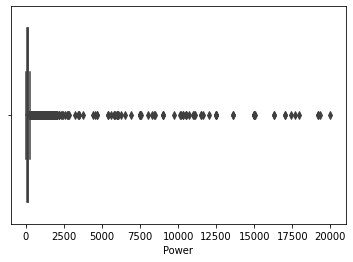

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


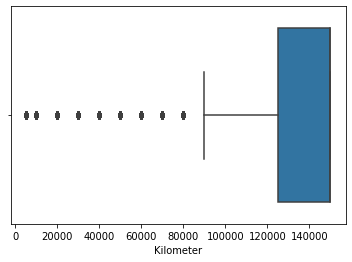

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


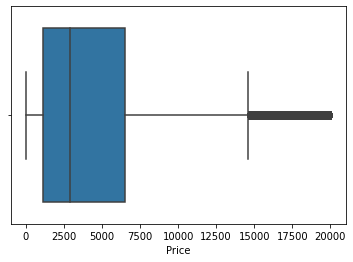

In [18]:
for a in ['Power','Kilometer','Price']:
    sns.boxplot(data[a]) 
    plt.show()

Видим явные аномалии в цене, надо сделать по ним срез. И много нулевых значений в цене и мощности, их можно заменить средним значением. Сделаем сводные таблицы и в них заменим на средние, а затем применим их к основному датасету

In [19]:
data = data.query('Price < 14000')
data = data.query('Price != 1')
power_new = data.pivot_table(columns='Model', values='Power', aggfunc='mean').astype('int').to_dict()
price_new = data.pivot_table(columns='Model', values='Price', aggfunc='mean').astype('int').to_dict()

In [20]:
def fill_0(row, cat, place, table):
    a = row[cat]
    b = table[a][place]
    if row[place] == 0:  
        row[place] = b
    return row
        
data = data.apply(fill_0, axis=1, args=('Model','Power', power_new))
data = data.apply(fill_0, axis=1, args=('Model','Price', price_new))

data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode
0,480,sedan,1993,manual,94,golf,150000,0,petrol,volkswagen,no,0,70435
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,0,90480
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0,33775


отрежем цены ниже 100 евро и уберем нулевые значения мощностей

In [21]:
data = data.query('Power != 0')
data = data.query('Price > 100')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299915 entries, 0 to 334658
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              299915 non-null  int64 
 1   VehicleType        299915 non-null  object
 2   RegistrationYear   299915 non-null  int64 
 3   Gearbox            299915 non-null  object
 4   Power              299915 non-null  int64 
 5   Model              299915 non-null  object
 6   Kilometer          299915 non-null  int64 
 7   RegistrationMonth  299915 non-null  int64 
 8   FuelType           299915 non-null  object
 9   Brand              299915 non-null  object
 10  Repaired           299915 non-null  object
 11  NumberOfPictures   299915 non-null  int64 
 12  PostalCode         299915 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 32.0+ MB


count    299915.000000
mean       2002.336242
std           6.313367
min        1960.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


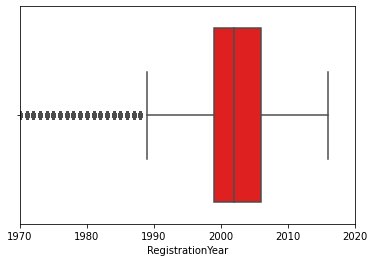

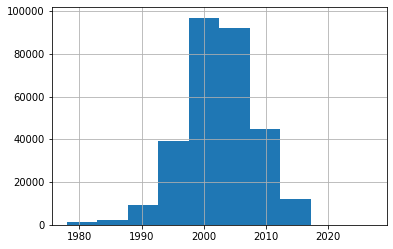

In [23]:
def boxplot_print(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    sns.boxplot(x=colum, color='red')   
    plt.show()
    colum.hist(bins=bins, range=((q1-3*iqr), (q3+3*iqr)))
    plt.show()
    
plt.xlim(1970, 2020)
boxplot_print(data['RegistrationYear'], 10)

count    297951.000000
mean       2002.534155
std           5.827572
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2006.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


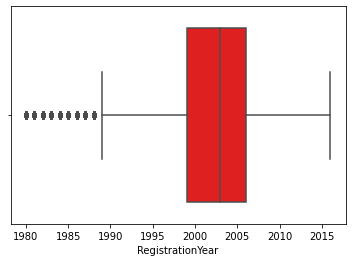

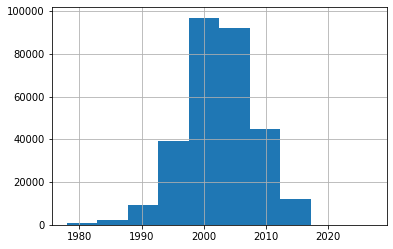

In [24]:
df_filtr = data.query("1980 <= RegistrationYear <= 2020")
boxplot_print(df_filtr['RegistrationYear'], 10)

count    297951.000000
mean        118.572010
std         181.528855
min           1.000000
25%          75.000000
50%         109.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64


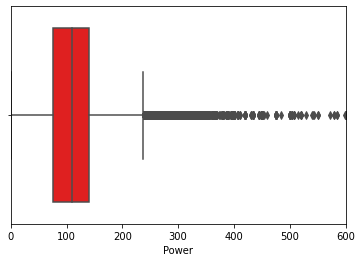

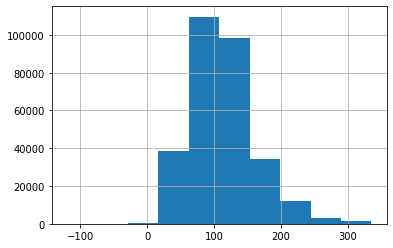

In [25]:
plt.xlim(0, 600)
boxplot_print(df_filtr['Power'], 10)

Кодирование данных:

In [26]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
0,480,1993,94,150000,0,0,70435,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,9800,2004,163,125000,8,0,90480,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1500,2001,75,150000,6,0,91074,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3600,2008,69,90000,7,0,60437,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,650,1995,102,150000,10,0,33775,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Данные готовы.

## Обучение моделей

Разделение на выборки, обучающие признаки и целевые: 

In [27]:
df_train, df_valid = train_test_split(data_ohe, test_size=0.2, random_state=12345)

df_test_size = df_valid.shape[0] / df_train.shape[0]
df_train, df_test = train_test_split(df_train, test_size=df_test_size, random_state=12345)

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']

features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']

features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(data_ohe.shape)

(299915, 307)


Разбиение на подвыборки для кросс-валидации

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

In [29]:
test_score = {}

### LinearRegression

In [30]:
%%time

line_reg_model = LinearRegression().fit(features_train, target_train)
predictions = line_reg_model.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
rmse_train

CPU times: user 11.8 s, sys: 5.92 s, total: 17.7 s
Wall time: 17.7 s


2222.7576682184495

In [31]:
%%time

predictions_valid = line_reg_model.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

CPU times: user 83.5 ms, sys: 41.1 ms, total: 125 ms
Wall time: 99.6 ms


In [32]:
%%time

predictions = line_reg_model.predict(features_valid)
print('RMSE модели линейной регрессии:', mean_squared_error(target_valid, predictions)**0.5)

RMSE модели линейной регрессии: 2227.8999640945835
CPU times: user 70.4 ms, sys: 173 ms, total: 243 ms
Wall time: 291 ms


In [33]:
test_score['LinearRegression'] = ['2227', '15.8 s', '69.7 ms']

### DecisionTreeRegressor

In [34]:
%%time
regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(10, 16)]
rty = [x for x in range(2, 4)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'min_samples_split':rty}]
print('Настройка гиперпараметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Наилучший набор параметров:")
print()
print(clf.best_params_)
print()
print("Результат:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, hyperparams in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, hyperparams))
print()

Настройка гиперпараметров

Наилучший набор параметров:

{'criterion': 'mse', 'max_depth': 14, 'min_samples_split': 3}

Результат:

1639.288195 for {'criterion': 'mse', 'max_depth': 10, 'min_samples_split': 2}
1639.780409 for {'criterion': 'mse', 'max_depth': 10, 'min_samples_split': 3}
1613.667109 for {'criterion': 'mse', 'max_depth': 11, 'min_samples_split': 2}
1613.518287 for {'criterion': 'mse', 'max_depth': 11, 'min_samples_split': 3}
1598.115060 for {'criterion': 'mse', 'max_depth': 12, 'min_samples_split': 2}
1597.282330 for {'criterion': 'mse', 'max_depth': 12, 'min_samples_split': 3}
1588.391988 for {'criterion': 'mse', 'max_depth': 13, 'min_samples_split': 2}
1587.726873 for {'criterion': 'mse', 'max_depth': 13, 'min_samples_split': 3}
1584.458714 for {'criterion': 'mse', 'max_depth': 14, 'min_samples_split': 2}
1583.886848 for {'criterion': 'mse', 'max_depth': 14, 'min_samples_split': 3}
1590.409700 for {'criterion': 'mse', 'max_depth': 15, 'min_samples_split': 2}
1590.827038

In [35]:
%%time
regr = (DecisionTreeRegressor(max_depth=14, min_samples_split=3, random_state=12345)
        .fit(features_train, target_train))


CPU times: user 4.27 s, sys: 139 ms, total: 4.41 s
Wall time: 4.42 s


In [36]:
%%time

predictions_valid = regr.predict(features_valid)
mse_test = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_test ** 0.5
rmse_valid

CPU times: user 51.2 ms, sys: 63.9 ms, total: 115 ms
Wall time: 122 ms


1562.4897446452974

In [37]:
test_score['DecisionTreeRegressor'] = ['1562', '4.46 s', '122 ms']

Вывод:

При увеличение числа деревьев, модель сильно переобучивается и качество предсказаний падает.

### RandomForestRegressor

In [ ]:
%%time
for estim in np.arange(37, 45):
    rf_regr = (RandomForestRegressor(max_depth=14, 
                                     n_estimators=estim,
                                     random_state=12345)
        .fit(features_train, target_train)
       )
    predictions = rf_regr.predict(features_train)
    mse = mean_squared_error(target_train, predictions)
    rmse = mse ** 0.5
    
    predictions_valid = rf_regr.predict(features_valid)
    mse_valid = mean_squared_error(target_valid, predictions_valid)
    rmse_valid = mse_valid ** 0.5
    
    print("n_estimators =", estim, ":")
    print("Результат проверки на обучающей  выборке", rmse)
    print("Результат проверки на валидационной выборке", rmse_valid)
    print()

n_estimators = 37 :
Результат проверки на обучающей  выборке 1235.2855761505414
Результат проверки на валидационной выборке 1418.5649915845097



In [ ]:
%%time
rf_regr = (RandomForestRegressor(max_depth=14,
                                 n_estimators=41,
                                 random_state=12345
                                )

           .fit(features_train, target_train)
          )


In [ ]:
%%time

predictions_valid = rf_regr.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
rmse_valid

In [ ]:
test_score['RandomForestRegressor']  = ['1418', '2min', '564 ms']

### LGBMRegressor

In [ ]:
import gc
gc.enable()

y = data['Price']
X = data.drop(['Price'], axis=1)

del data
gc.collect()

In [ ]:
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

In [ ]:
X.info()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=12345)

In [ ]:
category_features = [0, 2, 4, 7, 8, 9]

In [ ]:
%%time
estim = lgb.LGBMRegressor()
estim.fit(X_train, y_train, eval_metric='rmse', categorical_feature=category_features)


In [ ]:
%%time
predicted_valid = estim.predict(X_valid)
predicted_train = estim.predict(X_train)
print('The rmse of LGBMRegressor prediction on train:', mean_squared_error(y_train, predicted_train) ** 0.5)
print('The rmse of LGBMRegressor prediction on valid:', mean_squared_error(y_valid, predicted_valid) ** 0.5)

In [ ]:
test_score['LGBMRegressor']  = ['1363', '34.7 s', '2.61 s']

В данном шаге были обучены и проверены на валидационной выборке четыре модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor.

## Анализ моделей

In [ ]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['Качество', 'Время обучения', 'Время предсказания'], orient='index')
df_score

Выбираем лучшую модель, исходя из полученных результатов- это LightGBM, и проверяем ее на тестовой выборке.

In [ ]:
%%time

lgb_train = lgb.Dataset(X_train, y_train)

lgb_test = lgb.Dataset(X_train, y_train, reference=lgb_train)

parameters_light = {'metric': 'l2', 'max_depth':14,"random_state": 12345,"learning_rate":1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_test],
                verbose_eval=100)

In [ ]:
%%time

print("LightGBM:",(mean_squared_error(y_test,light.predict(X_test),squared=False)))

# Вывод:

Модели градиентного бустинга показали результаты лучше чем модели линейной регрессии и дерева решений. Наиболее точной оказалась модель LightGBMRegressor. При этом модели LinearRegression и DecisionTreeRegressor быстрее моделей градиентного бустинга.

На тестовой выборке получили результат хуже, чем на валидационной.